# Research question 2

#### 2. How often do users visit each other? Does it depend on whether they live in a city or not or on the season of the year?

### Concept

- for each user, check for friends check-ins in check-ins compared 

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from poisson_etest import poisson_etest
from sklearn.linear_model import LinearRegression
from geopy.distance import distance
from functions import load_data, discretize_world, home_locations, lives_in_city


%load_ext autoreload
%autoreload 2
%reload_ext autoreload

### Data

In [ ]:
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")
B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)
# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

In [ ]:
# Make a variable for city and plot colored by city
# Load cities
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_"

cities = pd.read_pickle('cities.pickle')

In [ ]:
%cd "/home/mogan/Desktop"
bk_checkins, bk_edges = load_data("Brightkite")
gw_checkins, gw_edges = load_data("Gowalla")

In [ ]:
# Since the computations are quite heavy, take a representative subset 
# (Jupyter crashes for the whole datasets for my computer)
n = 8000
bk_checkins = bk_checkins.head(n)#sample(n, random_state=23)
gw_checkins = gw_checkins.head(n)#sample(n, random_state=23)

In [8]:
## 2. Discretise the world
bk_checkins = discretize_world(bk_checkins)
gw_checkins = discretize_world(gw_checkins)

In [9]:
## 3. Compute home location
bk_home_locs = home_locations(bk_checkins)
gw_home_locs = home_locations(gw_checkins)

In [10]:
# Make a unique index for every check in, because there is no other unique variable
bk_checkins['check-in'] = bk_checkins.index
gw_checkins['check-in'] = gw_checkins.index

In [11]:
# Add home location for friend A
bk_checkins = bk_checkins.merge(bk_home_locs['location'], left_on = 'user_id', right_index = True).rename(columns = {'location': 'home_location'})
gw_checkins = gw_checkins.merge(gw_home_locs['location'], left_on = 'user_id', right_index = True).rename(columns = {'location': 'home_location'})

In [12]:
# Merge check-in data with the friend network dataframe
bk_checkins_merged = bk_checkins.merge(bk_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)
gw_checkins_merged = gw_checkins.merge(gw_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)

# Add each friend's B home location to the extended dataframe
bk_checkins_merged = bk_checkins_merged.merge(bk_home_locs, left_on = "to_id", right_index = True).drop(columns=['location'], axis = 1)
gw_checkins_merged = gw_checkins_merged.merge(gw_home_locs, left_on = "to_id", right_index = True).drop(columns=['location'], axis = 1)

In [13]:
# Calculate the distance between check-ins and friends home
bk_checkins_merged['distances_to_friend'] = bk_checkins_merged.apply(lambda x: distance((x['latitude_x'], x['longitude_x']), (x['latitude_y'], x['longitude_y'])).km, axis = 1)
gw_checkins_merged['distances_to_friend'] = gw_checkins_merged.apply(lambda x: distance((x['latitude_x'], x['longitude_x']), (x['latitude_y'], x['longitude_y'])).km, axis = 1)

In [14]:
# Investigate if a check-in was a friends visit or not 
# by grouping by check-in id's and checking if any distance is smaller than r
radius = 25
bk_friend_visited = bk_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()
gw_friend_visited = gw_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()

In [15]:
bk_checkins_merged['visited_friend'] = bk_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)
gw_checkins_merged['visited_friend'] = gw_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)

### How often do friends visit each other?

In [16]:
bk_friend_visited = bk_checkins_merged[bk_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]
gw_friend_visited = gw_checkins_merged[gw_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]


In [17]:
bk_friend_visited['data'] = 'Brightkite'
gw_friend_visited['data'] = 'Gowalla'

bk_gw_friends = bk_friend_visited.append(gw_friend_visited)
#gw_friend_visited.head()

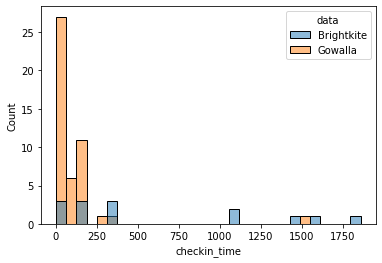

In [18]:
#sns.histplot(data = bk_gw_friends, x = 'checkin_time', hue = 'data', multiple="dodge", bins = 30);
sns.histplot(data = bk_gw_friends, x = 'checkin_time', hue = 'data', bins = 30);

In [ ]:
# Intermediately save the dataframes
#bk_checkins_merged.to_pickle("B_checkins_merged.pickle")
#gw_checkins_merged.to_pickle("G_checkins_merged.pickle")
#bk_checkins.to_pickle("B_checkins_MS4.pickle")
#gw_checkins.to_pickle("G_checkins_MS4.pickle")

### Does it depend on whether they live in a city or not or on the season of the year?

In [23]:
cities.shape

(1585, 12)

In [24]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area,density,radius
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.07,17308.928156,26.427148
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.50,4890.619469,47.413749
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.00,19957.547170,21.734118
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.00,5362.801378,37.232238
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.82,15654.791771,21.666790


In [ ]:
bk_checkins_merged.head(3)

In [38]:
B_homes = B_homes[B_homes.index.isin(bk_checkins['user_id'])]#.isin()


In [39]:
B_homes

,longitude,latitude,country,user_id
user_id,,,,
0,-105.009140,39.756108,US,0
1,-122.353819,37.581821,US,1
2,-105.041977,39.771737,US,2
3,-122.424280,37.765768,US,3
4,24.937299,60.173985,FI,4
5,-122.421897,37.752990,US,5


In [31]:
cities

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area,density,radius
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.07,17308.928156,26.427148
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.50,4890.619469,47.413749
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.00,19957.547170,21.734118
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.00,5362.801378,37.232238
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.82,15654.791771,21.666790
...,...,...,...,...,...,...,...,...,...,...,...,...
11167,Traverse City,Traverse City,44.7547,-85.6035,United States,US,USA,50522.0,1840003946,8.66,5833.949192,1.660290
11169,East Hartford,East Hartford,41.7634,-72.6152,United States,US,USA,50453.0,1840034618,18.70,2698.021390,2.439753
11170,Irondequoit,Irondequoit,43.2096,-77.5705,United States,US,USA,50427.0,1840058201,16.82,2998.038050,2.313865
11179,Mishawaka,Mishawaka,41.6736,-86.1669,United States,US,USA,50363.0,1840014695,17.97,2802.615470,2.391658


In [ ]:
lives_in_city(B_homes, cities)

In [ ]:
merge = B_homes.merge(cities, left_on = 'country', right_on = 'iso2')
merge['distance_to_city'] = merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
lives_urban = merge.groupby("user_id").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
lives_urban = lives_urban.rename(columns = {0:'lives_urban'})
homes = B_homes.merge(lives_urban, left_on = 'user_id', right_index = True)
homes

,longitude,latitude,country,user,lives_urban
user_id,,,,,
0,-105.009140,39.756108,US,0,False
1,-122.353819,37.581821,US,1,False
2,-105.041977,39.771737,US,2,False
3,-122.424280,37.765768,US,3,False
5,-122.421897,37.752990,US,5,False
